# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse NAc cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm
rmm.reinitialize(managed_memory=True)
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)

import calculation_tool as ct
import gc
import cupy as cp
#gc.collect()
#cp.get_default_memory_pool().free_all_blocks()

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [ ]:
import os
import urllib.request
import gzip
import shutil

url_list=[r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482106&format=file&file=GSM5482106%5FNAc%5FWT%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482106&format=file&file=GSM5482106%5FNAc%5FWT%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482106&format=file&file=GSM5482106%5FNAc%5FWT%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482107&format=file&file=GSM5482107%5FNAc%5FWT%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482107&format=file&file=GSM5482107%5FNAc%5FWT%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482107&format=file&file=GSM5482107%5FNAc%5FWT%5FRep2%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482108&format=file&file=GSM5482108%5FNAc%5FSetd1aHet%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482108&format=file&file=GSM5482108%5FNAc%5FSetd1aHet%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482108&format=file&file=GSM5482108%5FNAc%5FSetd1aHet%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482109&format=file&file=GSM5482109%5FNAc%5FSetd1aHet%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482109&format=file&file=GSM5482109%5FNAc%5FSetd1aHet%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482109&format=file&file=GSM5482109%5FNAc%5FSetd1aHet%5FRep2%5Fmatrix%2Emtx%2Egz"]

def download_file(url, dir, file_name):
    full_path = os.path.join(dir, file_name)
    urllib.request.urlretrieve(url, full_path)
    # 以下のコメントアウト部分を活用する場合は、解凍の手順を追加することができます。
    # with gzip.open(full_path, 'rb') as f_in:
    #     with open(full_path[:-3], 'wb') as f_out:
    #         shutil.copyfileobj(f_in, f_out)

dir = "/data/mouse_NAc/"

for url in url_list:
    acc = url.split("acc=")[1].split("&")[0]
    file_name_from_url = url.split("file=")[1]

    # WTとSetd1aHetのサブフォルダを作成
    subfolder = "WT" if "WT" in file_name_from_url else "Setd1aHet"
    acc_dir = os.path.join(dir,subfolder, acc)
    os.makedirs(acc_dir, exist_ok=True)

    # 標準的なファイル名に変更（.gzを取り除く）
    standard_file_name = file_name_from_url.split('_')[-1].replace('.gz', '')
    
    if "barcodes" in file_name_from_url:
        standard_file_name = "barcodes.tsv.gz"
    elif "features" in file_name_from_url:
        standard_file_name = "features.tsv.gz"
    elif "matrix" in file_name_from_url:
        standard_file_name = "matrix.mtx.gz"
    
    # ファイルをダウンロード
    download_file(url, acc_dir, standard_file_name)


In [ ]:
# ダウンロードディレクトリ
base_dir = "/data/mouse_NAc/"

def read_10x_mtx(path, label):
    """10x mtxフォーマットのデータを読み込み、指定されたラベルを追加します。"""
    adata = sc.read_10x_mtx(
        path,
        var_names='gene_symbols',
        cache=True
    )
    adata.obs['label'] = label
    return adata

labels = ["WT", "Setd1aHet"]

all_adatas = []

for label in labels:
    label_dir = os.path.join(base_dir, label)
    gsm_dirs = [os.path.join(label_dir, d) for d in os.listdir(label_dir) if os.path.isdir(os.path.join(label_dir, d))]
    
    for gsm_dir in gsm_dirs:
        if os.path.exists(gsm_dir):
            all_adatas.append(read_10x_mtx(gsm_dir, label))

# 全てのAnnDataオブジェクトを1つに結合
combined_adata = all_adatas[0].concatenate(all_adatas[1:], join='outer')

# .h5ad形式で保存
combined_adata.write("/data/mouse_NAc/combined_data.h5ad")

## load data

In [ ]:
import calculation_tool as ct
file_path="/data/mouse_NAc/combined_data.h5ad"
add_markers=["ADORA2A","CAMK2A","CAMK2B","PENK","PDYN"]
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None,add_markers=add_markers)
GPCR_df.to_csv("/data/mouse_NAc/combined_data_GPCR_df.csv")

In [3]:
file_path="/data/mouse_NAc/combined_data_processed.h5ad"
adata=anndata.read_h5ad(file_path)

In [4]:
import calculation_tool as ct
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)

In [ ]:
GPCR_list

In [5]:
GPCR_df=pd.read_csv("/data/mouse_NAc/combined_data_GPCR_df.csv")
#ct.drug_titeration(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
sc.pl.umap(adata, color=["leiden"])
# --- 事前準備 ---
# もし "leiden" がカテゴリ型でなければ、数値順（整数に変換してソート）でカテゴリに変換する
if not pd.api.types.is_categorical_dtype(adata.obs["leiden"]):
    leiden_order = sorted(adata.obs["leiden"].unique(), key=lambda x: int(x))
    adata.obs["leiden"] = pd.Categorical(adata.obs["leiden"], categories=leiden_order, ordered=True)

# leiden の順序（カテゴリ）を取得
cluster_order = adata.obs["leiden"].cat.categories

# sc.pl.umapで使われた色は通常 adata.uns["leiden_colors"] に格納されている
# ここでは、cluster_order の順番と対応していると仮定
colors = adata.uns.get("leiden_colors")
if colors is None:
    raise ValueError("adata.uns['leiden_colors'] が見つかりません。sc.tl.leiden などで設定してください。")

# クラスター毎の色の対応辞書を作成
cluster2color = dict(zip(cluster_order, colors))

# --- クロザピン選択細胞の割合の計算 ---
# "is_clz_selective" が bool でない場合、ブール値に変換（ここでは文字列比較を例示）
adata.obs["is_clz_selective_bool"] = adata.obs["is_clz_selective"].astype(str) == "True"

# 各クラスター内での True の割合を計算し、100倍してパーセントにする
clz_percentage = adata.obs.groupby("leiden")["is_clz_selective_bool"].mean() * 100

# クラスターの並び順を cluster_order に合わせる
clz_percentage = clz_percentage.reindex(cluster_order)

# --- 棒グラフの描画 ---
plt.figure(figsize=(8, 6))
# 各棒の色を cluster2color から取得して設定
bars = plt.bar(clz_percentage.index, clz_percentage.values,
               color=[cluster2color[cluster] for cluster in clz_percentage.index])

plt.xlabel("Leiden Cluster")
plt.ylabel("% of clz selective cell")
plt.title("Percentage of Clozapine Selective Cells per Leiden Cluster")
plt.ylim(bottom=0)  # y軸の下限を 0 に設定
plt.show()


In [ ]:
marker_genes_dict = {
    "Neuron": ["RBFOX3", "MAP2", "SLC17A7", "SATB2", "CUX2","BCL11B", "FEZF2","TLE4", "FOXP2","GAD1","PVALB","SST","VIP"],
    "Astrocyte": ["GFAP", "AQP4", "ALDH1L1"],
    "Oligodendrocyte": ["MBP", "MOG", "OLIG1", "OLIG2"],
    "Microglia": ["TMEM119", "AIF1", "CD68", "CX3CR1"],
    "Endothelial": ["CLDN5", "PECAM1", "VWF"],
    "OPC": ["PDGFRA", "CSPG4"],
    "Ependymal": ["FOXJ1"]
}
sc.pl.dotplot(adata, marker_genes_dict, "leiden")

In [6]:
GPCR_file_path=r"/data/mouse_NAc/combined_data_GPCR_df.csv"
GPCR_df = pd.read_csv(GPCR_file_path, index_col=0)
GPCR_adata=anndata.AnnData(X=GPCR_df)
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)

In [ ]:
import calculation_tool as ct

drug_conc=10**4
results_df_sorted,all_responses=ct.sim_inhibit_pattern(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,n_pattern=10000)
dir="/data/mouse_NAc"
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=20, top_n_for_heatmap=20, scatter_n=500)

In [ ]:
sc.pl.umap(adata, color=["ADORA2A_raw"])
sc.pl.umap(adata, color=["DRD2_raw"])
sc.pl.umap(adata, color=["DRD1_raw"])

In [7]:
adata.obs["is_D2SPN"] = (adata.obs["ADORA2A_raw"]>1) & (adata.obs["DRD2_raw"]>1)& (adata.obs["DRD1_raw"]<1)
print(sum(adata.obs["is_D2SPN"]))
adata.obs["is_D2SPN"] =adata.obs["is_D2SPN"].astype("category")

228


In [ ]:
drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_D2SPN", selected_label=True,n_inhibited=3)
dir="/data/mouse_NAc/D2-SPN-threshold-05_r_3"

if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Pattern_1: {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': True, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': True, 'HTR7_raw': False, 'DRD1_raw': True, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': True, 'DRD5_raw': True, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': True, 'CHRM2_raw': True, 'CHRM3_raw': True, 'CHRM4_raw': True, 'CHRM5_raw': True, 'ADRA1A_raw': True, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2B_raw': True, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': True, 'HTR4_raw': False, 'HTR5A_raw': True, 'HTR6_raw': False, 'HTR7_raw': True, 'DRD1_raw': False, 'DRD2_raw': True, 'DRD3_raw': True, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': True, 'HRH3_raw': False, 'CHRM1_raw': Fa

Simulating drug responses: 100%|██████████| 10000/10000 [05:33<00:00, 29.96it/s]


      pattern_name                                            pattern  \
5779  Pattern_5780  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
7894  Pattern_7895  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
2430  Pattern_2431  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
6311  Pattern_6312  {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_...   
9282  Pattern_9283  {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_...   

            diff  
5779  140.758057  
7894  139.042344  
2430  139.001874  
6311  137.081151  
9282  131.646947  


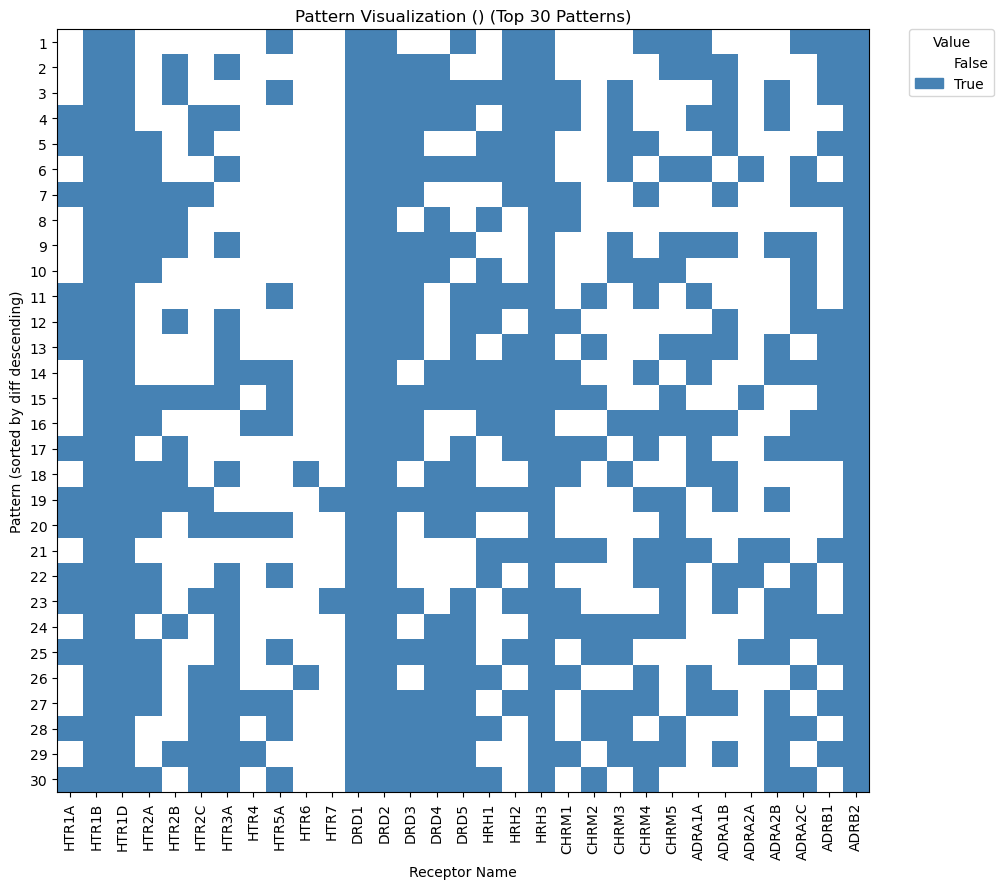

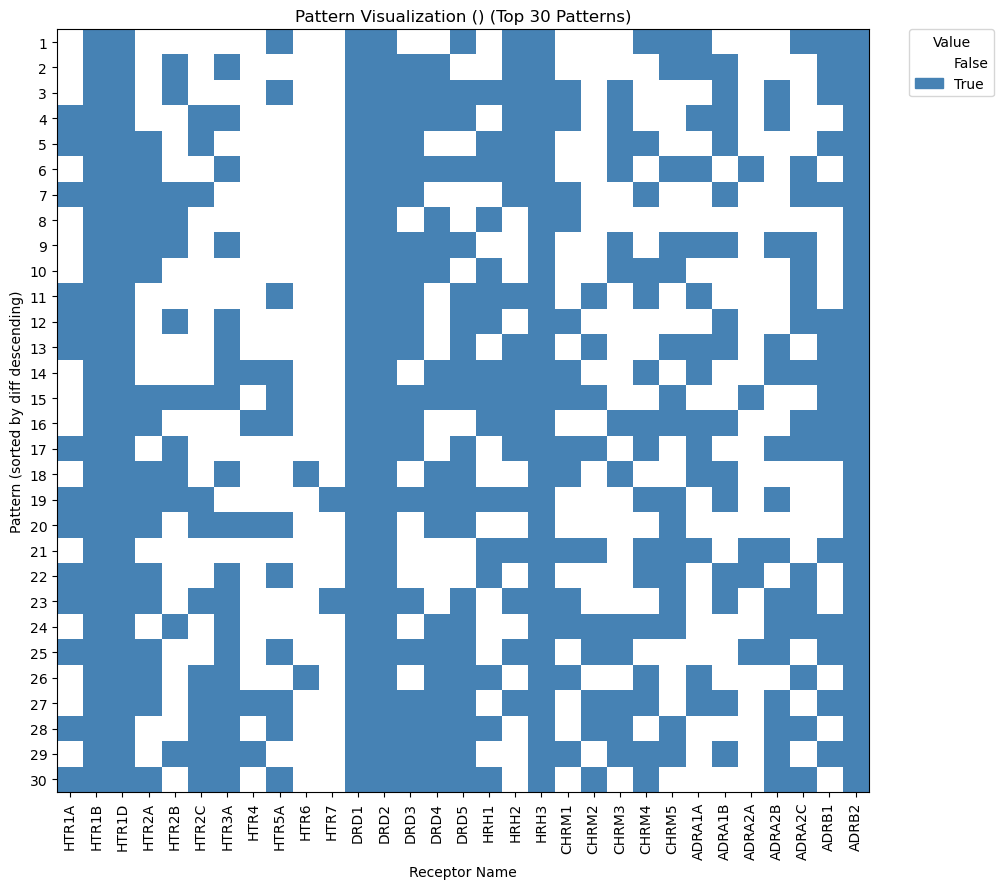

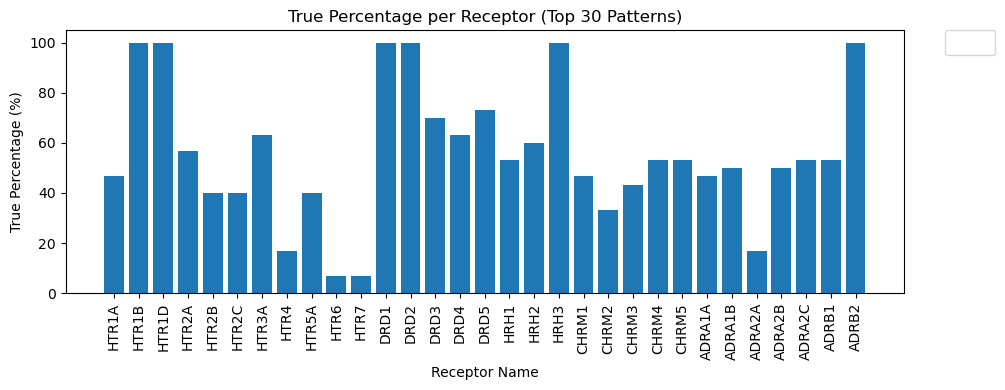

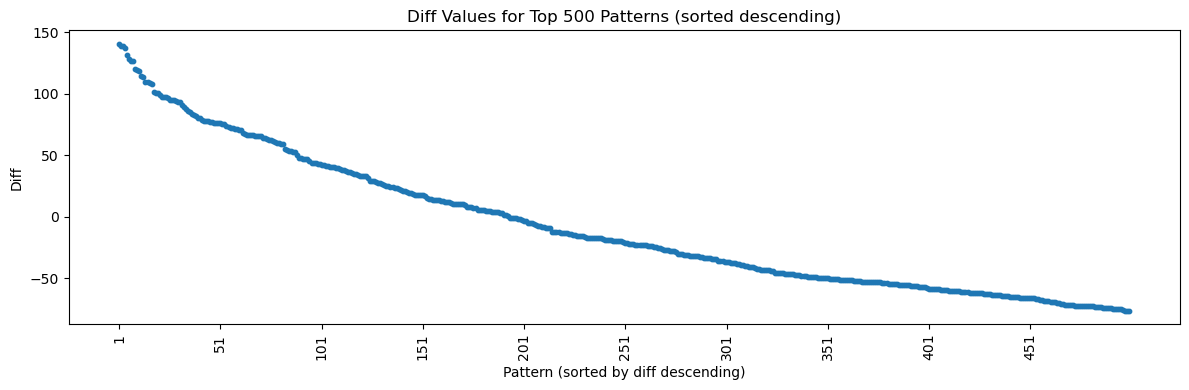

In [11]:
drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_D2SPN", selected_label=True,n_inhibited=0)
dir="/data/mouse_NAc/D2-SPN-threshold-1_random"

if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

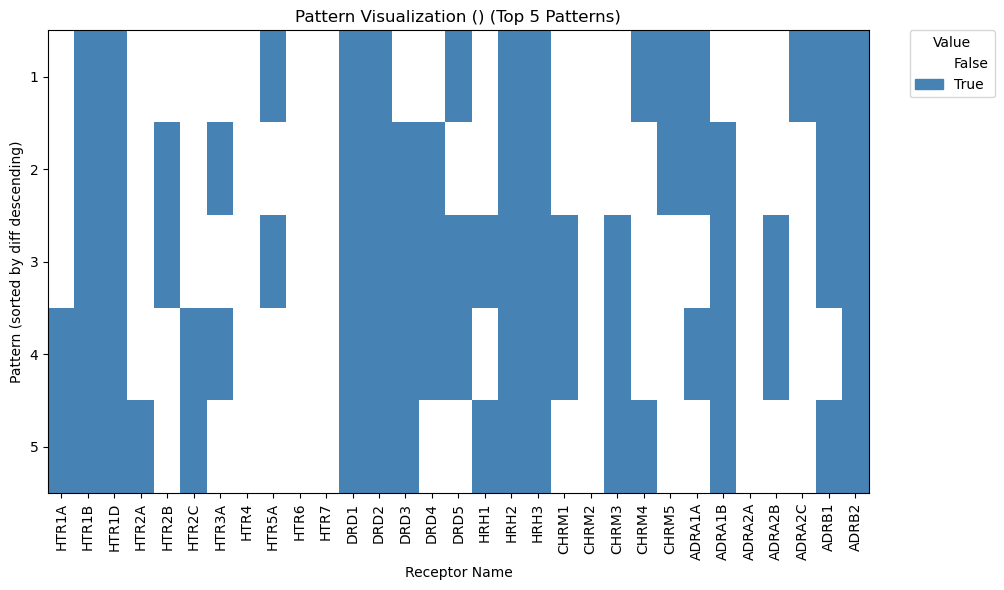

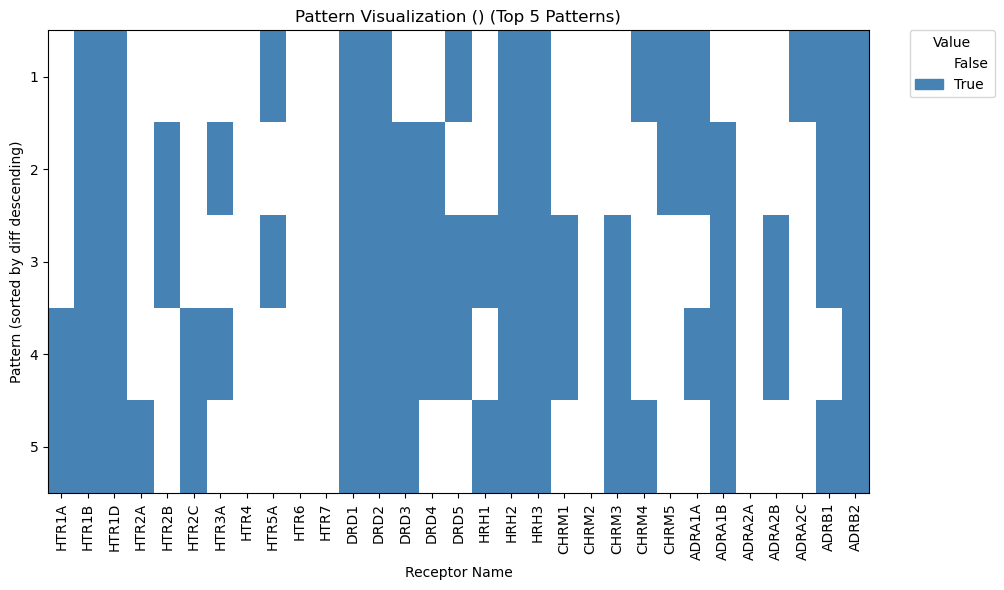

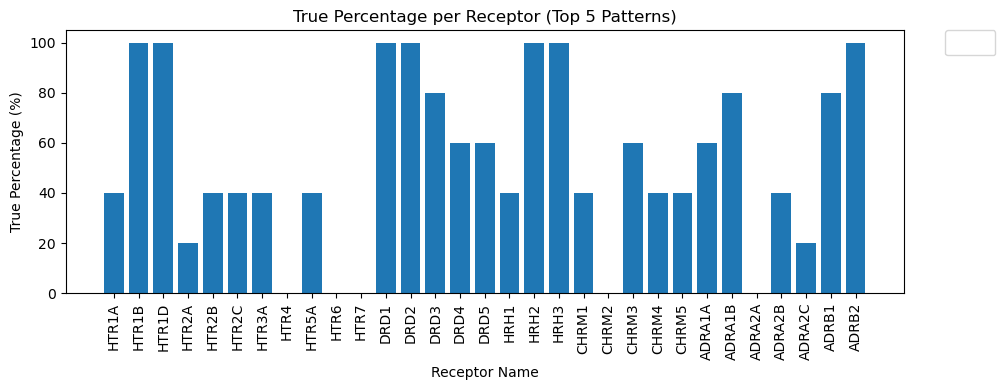

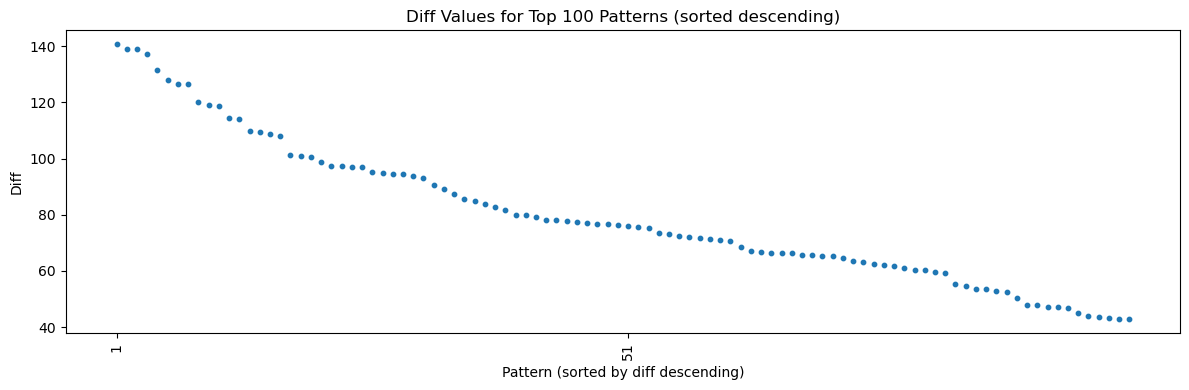

In [13]:
dir="/data/mouse_NAc/D2-SPN-threshold-1_random"
results_df_sorted=pd.read_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses=pd.read_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=5, top_n_for_heatmap=5, scatter_n=100)

Generating inhibition patterns:   0%|          | 0/31465 [00:00<?, ?it/s]

Generating inhibition patterns: 100%|██████████| 31465/31465 [00:00<00:00, 297913.91it/s]


Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM4_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2B_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, '

Simulating drug responses: 100%|██████████| 31465/31465 [20:43<00:00, 25.31it/s]


        pattern_name                                            pattern  \
26706  Pattern_26707  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
6579    Pattern_6580  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
6591    Pattern_6592  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
9855    Pattern_9856  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
9867    Pattern_9868  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   

             diff  
26706  -85.683320  
6579  -115.998988  
6591  -125.367673  
9855  -156.034733  
9867  -165.403418  


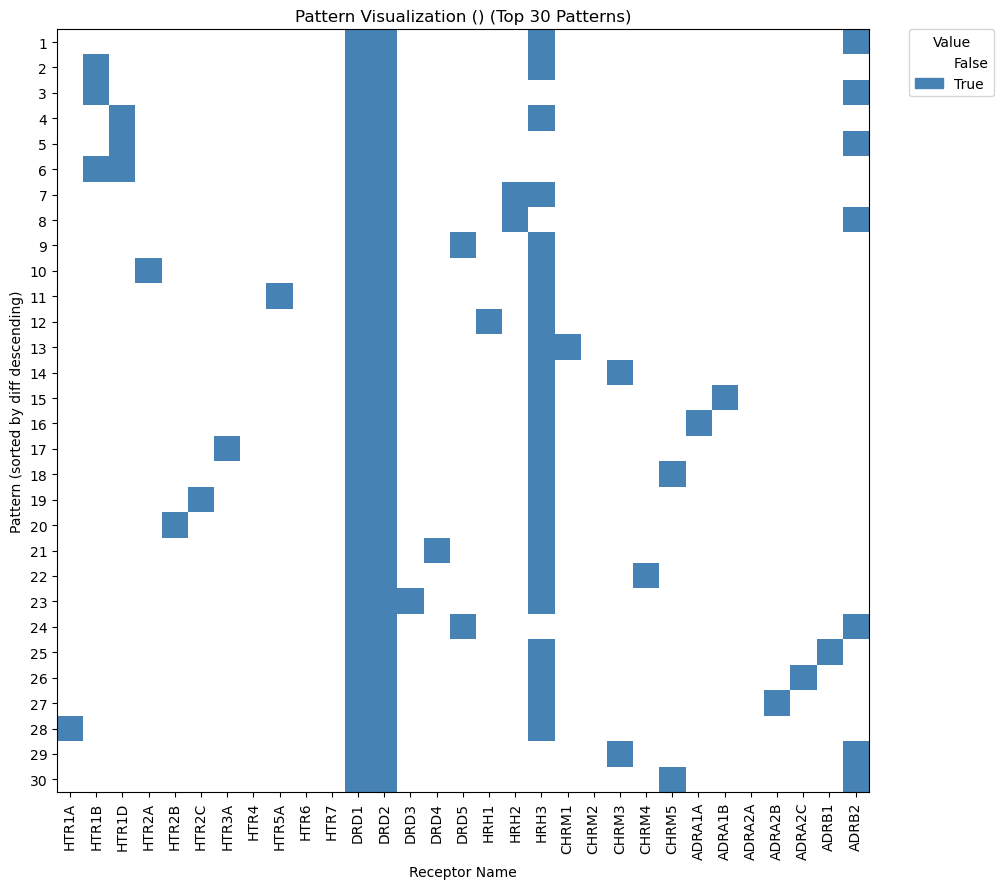

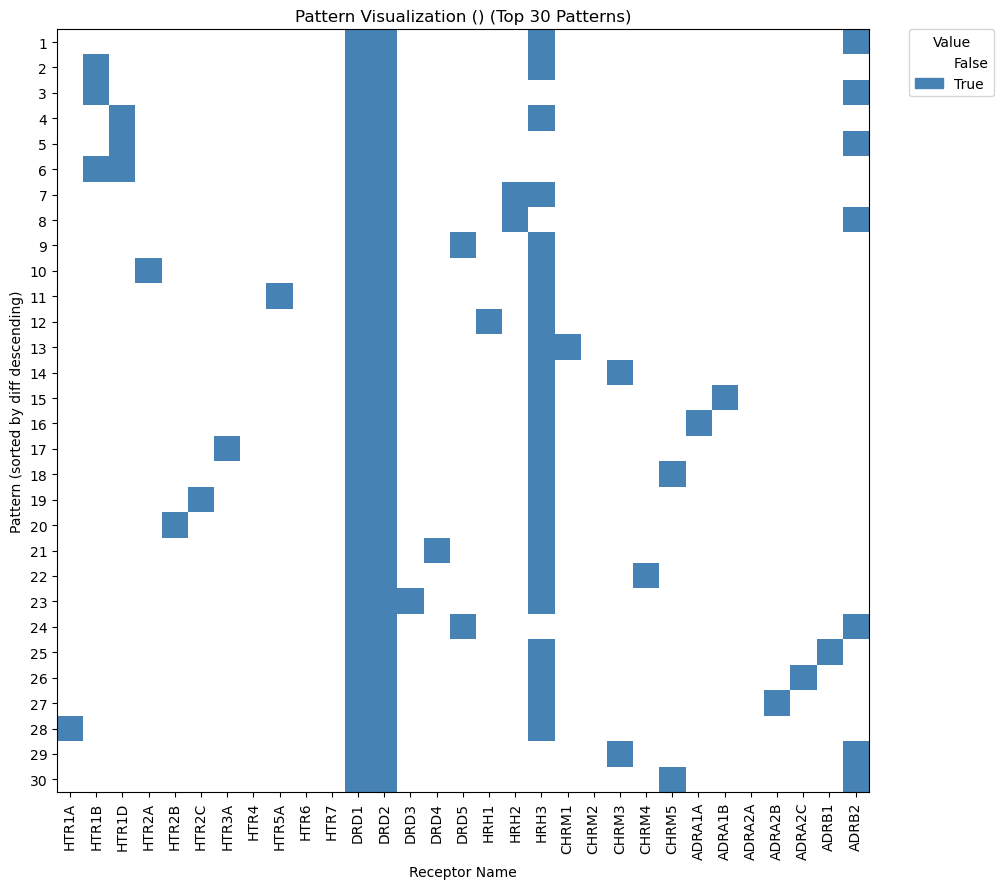

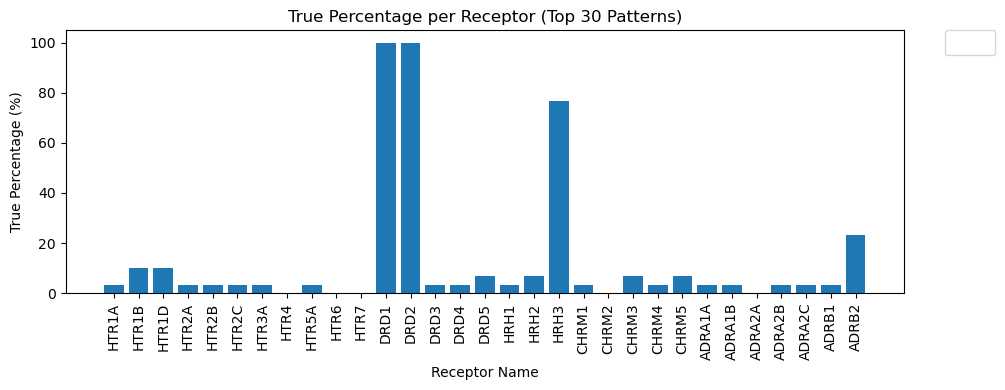

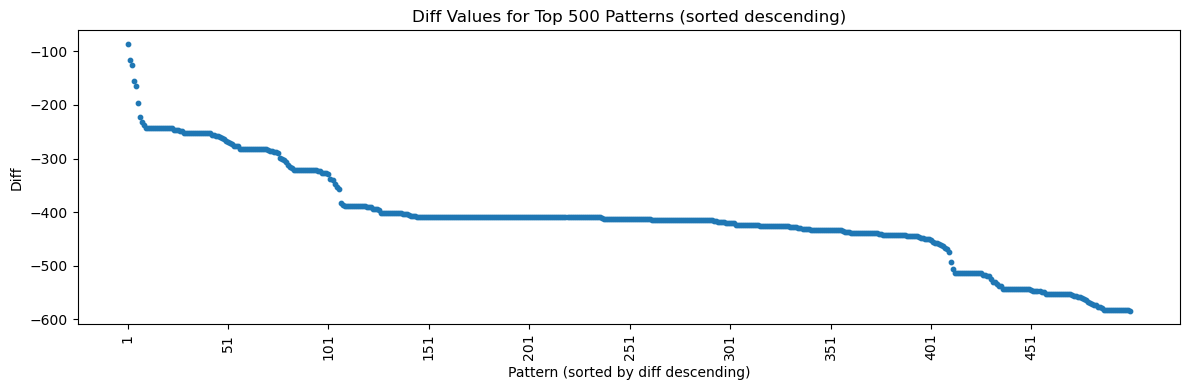

In [ ]:
drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_D2SPN", selected_label=True,n_inhibited=4)
dir="/data/mouse_NAc/D2-SPN-threshold-1_4r"

if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Generating inhibition patterns: 100%|██████████| 4495/4495 [00:00<00:00, 163489.07it/s]


Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM4_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2B_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False,

Simulating drug responses: 100%|██████████| 4495/4495 [02:53<00:00, 25.84it/s]


      pattern_name                                            pattern  \
3360  Pattern_3361  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
3372  Pattern_3373  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
651    Pattern_652  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
1029  Pattern_1030  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
3359  Pattern_3360  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   

            diff  
3360 -242.265400  
3372 -251.634084  
651  -281.949753  
1029 -321.985498  
3359 -389.241423  


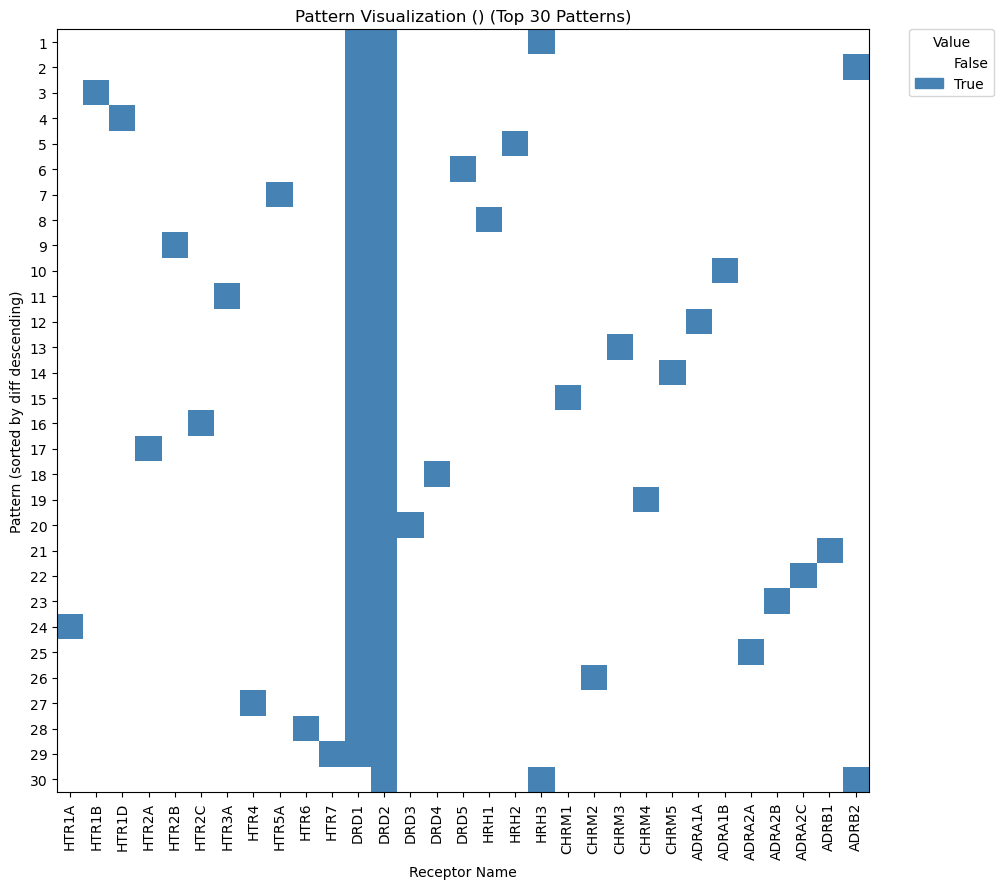

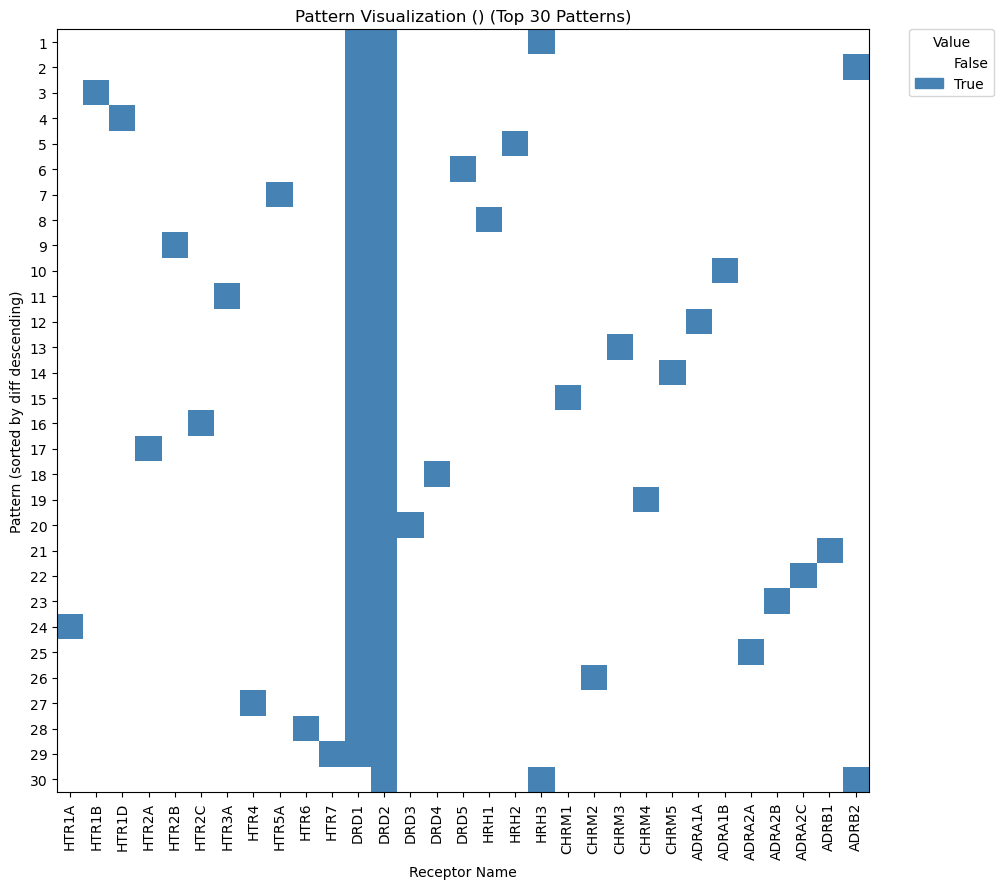

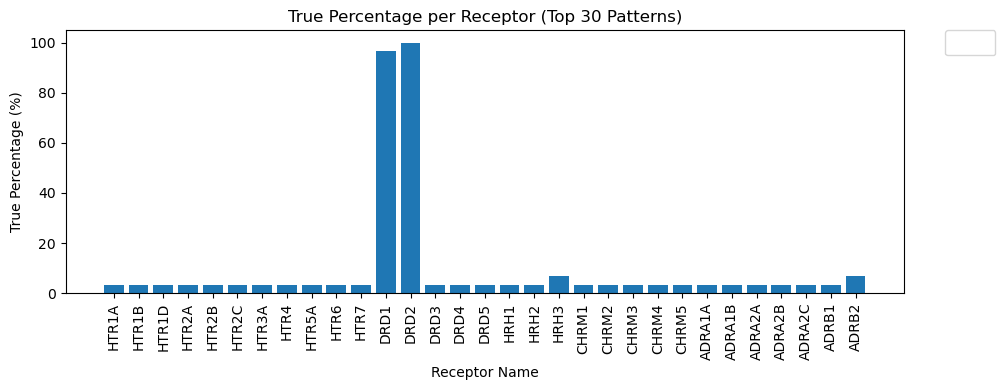

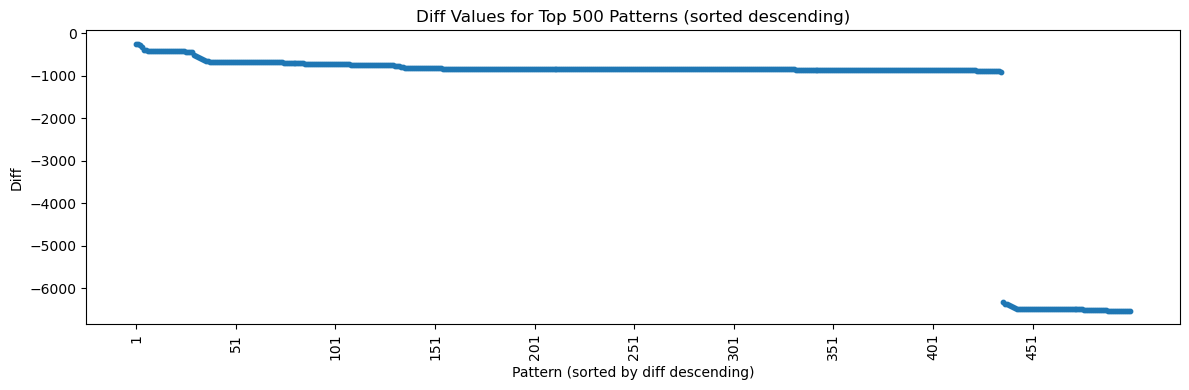

In [14]:
drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_D2SPN", selected_label=True,n_inhibited=3)
dir="/data/mouse_NAc/D2-SPN-threshold-1_3r"

if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Generating inhibition patterns:   0%|          | 0/31465 [00:00<?, ?it/s]

Generating inhibition patterns: 100%|██████████| 31465/31465 [00:00<00:00, 297913.91it/s]


Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM4_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2B_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, '

Simulating drug responses: 100%|██████████| 31465/31465 [20:43<00:00, 25.31it/s]


        pattern_name                                            pattern  \
26706  Pattern_26707  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
6579    Pattern_6580  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
6591    Pattern_6592  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
9855    Pattern_9856  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
9867    Pattern_9868  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   

             diff  
26706  -85.683320  
6579  -115.998988  
6591  -125.367673  
9855  -156.034733  
9867  -165.403418  


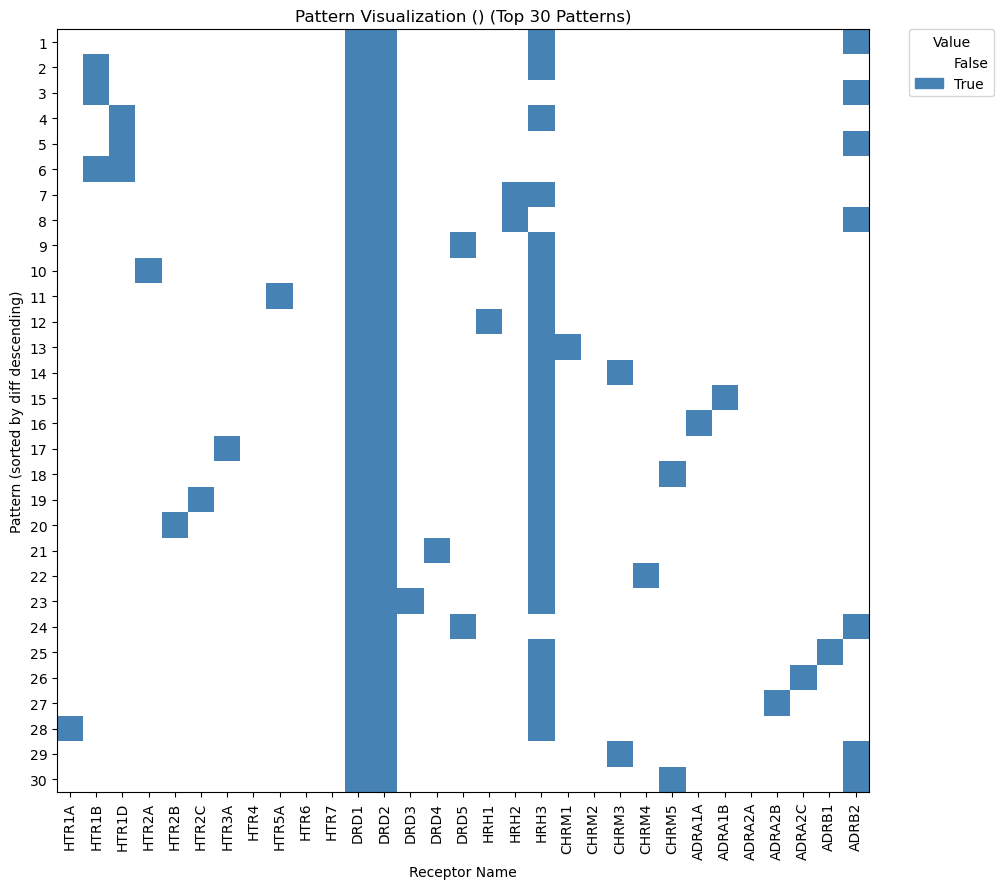

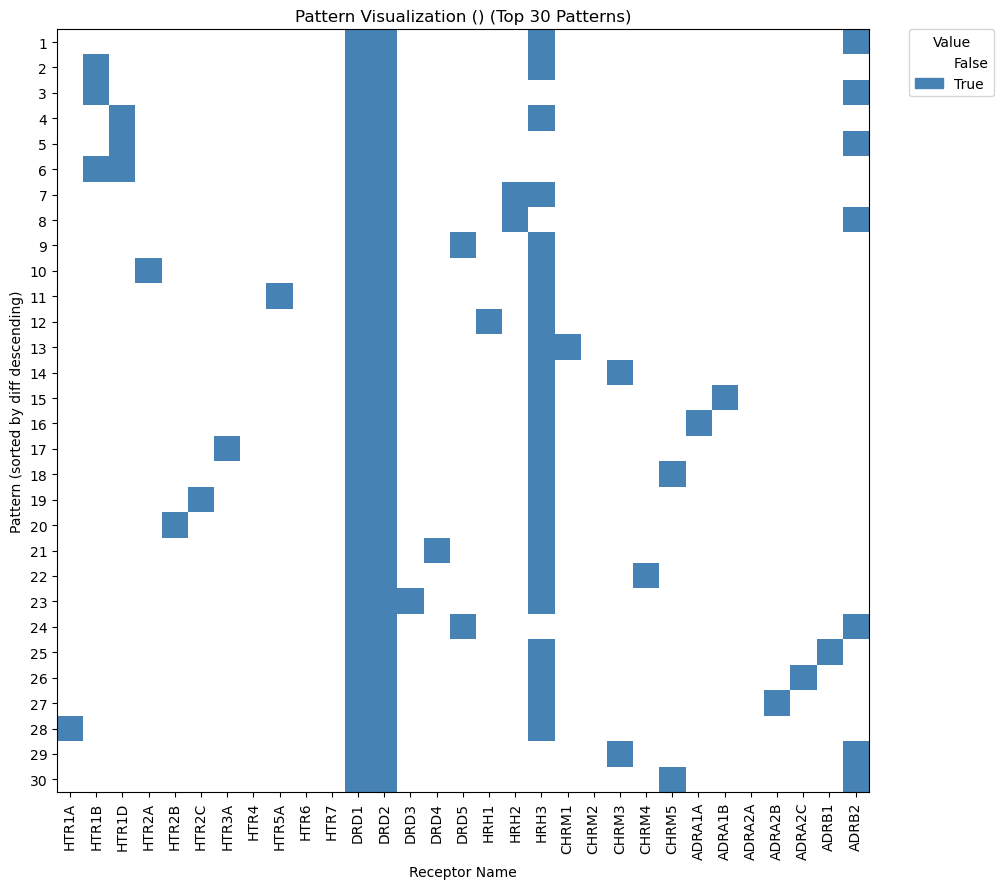

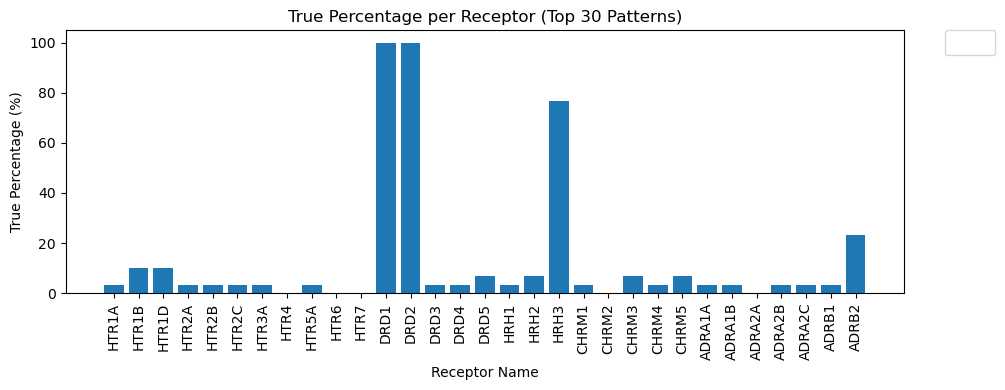

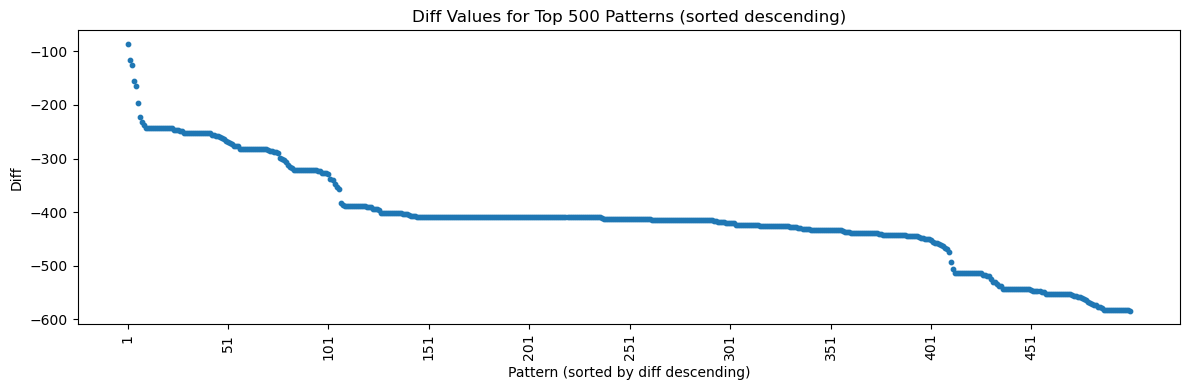

In [ ]:
drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_D2SPN", selected_label=True,n_inhibited=4)
dir="/data/mouse_NAc/D2-SPN-threshold-1_4r"

if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

In [ ]:
adata.obs["is_D2SPN"] = (adata.obs["ADORA2A_raw"]>0.5) & (adata.obs["DRD2_raw"]>0.5)& (adata.obs["DRD1_raw"]<1)
print(sum(adata.obs["is_D2SPN"]))
adata.obs["is_D2SPN"] =adata.obs["is_D2SPN"].astype("category")

In [ ]:
drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_D2SPN", selected_label=True,n_inhibited=3)
dir="/data/mouse_NAc/D2-SPN-threshold-1_5r"

if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

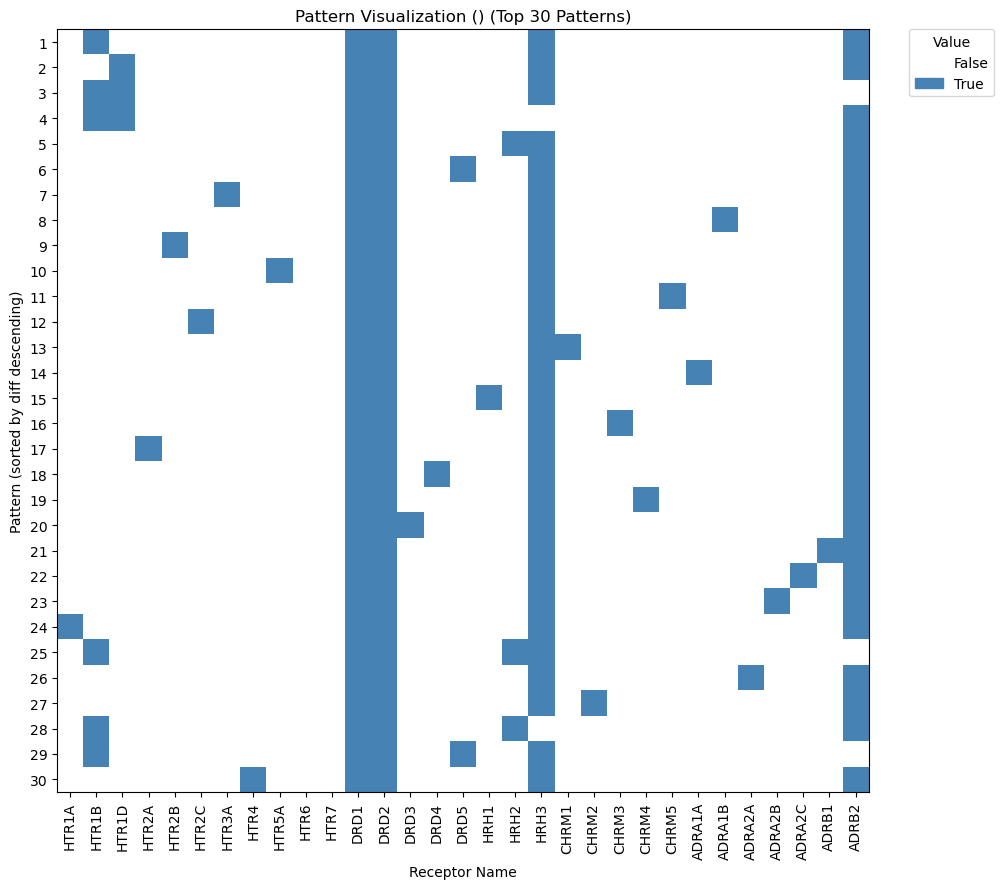

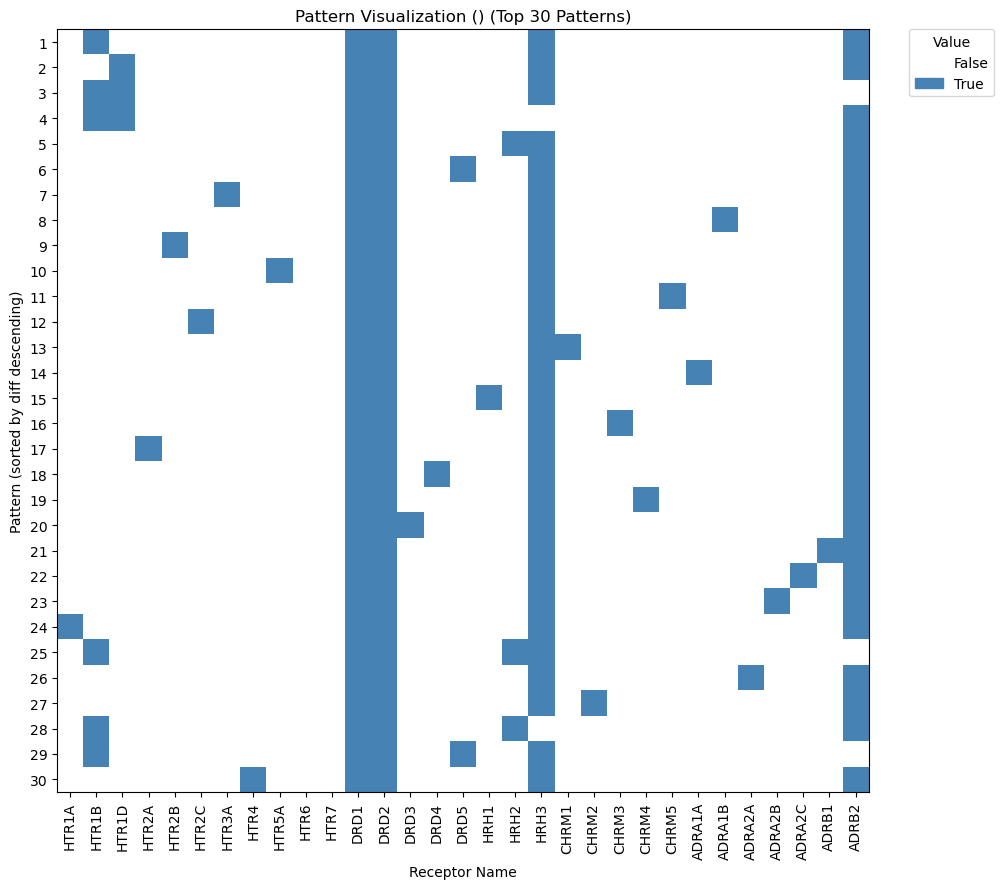

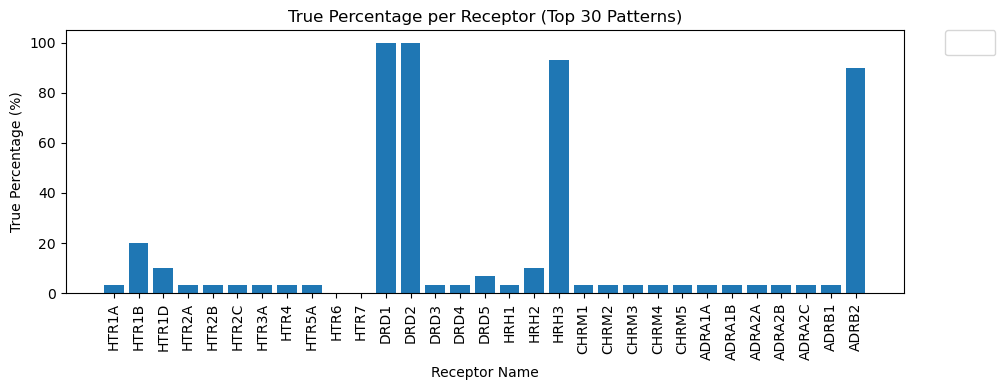

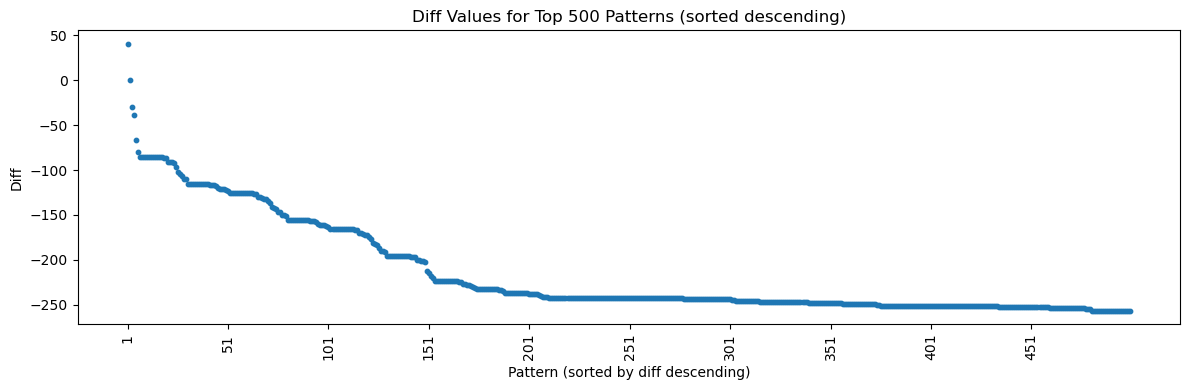

In [2]:
dir="/data/mouse_NAc/D2-SPN-threshold-1_5r"

results_df_sorted=pd.read_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses=pd.read_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

In [ ]:
drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_D2SPN", selected_label=True,n_inhibited=4)
dir="/data/mouse_NAc/D2-SPN-threshold-1_4r"

if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_pickle(os.path.join(dir,"results_df_sorted_3r.pkl"))
all_responses.to_pickle(os.path.join(dir,"all_responses_3r.pkl"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Generating inhibition patterns:   0%|          | 0/31465 [00:00<?, ?it/s]

Generating inhibition patterns: 100%|██████████| 31465/31465 [00:00<00:00, 291874.71it/s]


Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM4_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2B_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, '

Simulating drug responses:   2%|▏         | 594/31465 [00:23<20:47, 24.74it/s]